# Imports

In [18]:
import numpy as np
import random
import heapq
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Environment

In [19]:
class DisasterZoneEnv:
    """
    Simulates a 2D grid for a drone exploring a disaster zone.
    """

    def __init__(self, width=8, height=8, num_obstacles=5, num_survivors=3, 
                 num_resources=2, initial_energy=20, dynamic=False, 
                 predefined_grid=None, seed=None, recharge_amount=None):
        self.width = width
        self.height = height
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_resources = num_resources
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.dynamic = dynamic
        self.recharge_amount = recharge_amount
        self.dynamic_changes = 0

        self.action_space = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)} 

        if seed:
            random.seed(seed)
            np.random.seed(seed)

        if predefined_grid is not None:
            self.load_predefined_grid(predefined_grid)
        else:
            self.reset()

    def reset(self):
        """Initializes the grid with random obstacles, survivors, and resources."""
        self.grid = np.zeros((self.height, self.width), dtype=int)

        for i in range(self.num_obstacles):
            x, y = self.get_random_empty_cell()
            self.grid[x, y] = 1  # Obstacle

        for i in range(self.num_survivors):
            x, y = self.get_random_empty_cell()
            self.grid[x, y] = 2  # Survivor

        for i in range(self.num_resources):
            x, y = self.get_random_empty_cell()
            self.grid[x, y] = 3  # Resource

        # Drone's starting position
        self.drone_x, self.drone_y = self.get_random_empty_cell()

        # initial energy lvl
        self.energy = self.initial_energy

        return self.get_state()


    def load_predefined_grid(self, scenario):
        """loads up a predefined grid as a scenario"""
        scenario = np.array(scenario, dtype=object)

        self.height, self.width = scenario.shape

        self.grid = np.zeros((self.height, self.width), dtype=int)

        drone_found_flag = False

        for row in range(self.height):
            for col in range(self.width):
                cell_value = scenario[row, col]
                if cell_value == 'D':
                    # If we've already encountered 'D' then it's an error to have multiple drone starts.
                    if drone_found_flag:
                        raise ValueError("Scenario error: multiple 'D' positions found.")
                    # Record the drone's coordinates
                    self.drone_x, self.drone_y = row, col
                    drone_found_flag = True
                else:
                    # Convert whatever numeric character is in scenario to int
                    self.grid[row, col] = int(cell_value)

        if not drone_found_flag:
            raise ValueError("No starting position 'D' found in scenario. Please check your scenario definition")
        self.energy = self.initial_energy

    def get_random_empty_cell(self):
        """
        Chooses a random cell in the grid that happens to be empty (value 0).
        Continues sampling random coordinates until it finds one.
        """
        while True:
            row = random.randint(0, self.height - 1)
            col = random.randint(0, self.width - 1)
            if self.grid[row, col] == 0:
                return row, col


    def step(self, action):
        """
        Executes a single move in the grid based on 'action' and returns:
        - The updated state (drone position, energy, surroundings),
        - The immediate reward for this move,
        - A boolean indicating if the currrent episode is done
        """

        # Decompose the action chosen into a change d in (x, y)
        dx, dy = self.action_space[action]

        next_x = self.drone_x + dx
        next_y = self.drone_y + dy

        # Small negative reward for taking a step (Discourage unnecessary moves)
        reward = -1.0
        done = False

        # Check boundaries and obstacles
        if not (0 <= next_x < self.height and 0 <= next_y < self.width):
            # Out-of-bounds penalty (-10)
            reward -= 10.0
        elif self.grid[next_x, next_y] == 1:
            # Obstacle collision penalty (-10)
            reward -= 10.0
        else:
            self.drone_x = next_x
            self.drone_y = next_y
            cell_value = self.grid[next_x, next_y]
            # Evaluate what's in the new cell
            if cell_value == 2:  # Survivor
                reward += 10.0
                self.grid[next_x, next_y] = 0  # Remove survivor
            elif cell_value == 3:  # Resource
                reward += 5.0
                recharge_amount = self.recharge_amount or self.initial_energy # replenish energy to full if recharge amount not specified
                self.energy = min(self.energy + recharge_amount, self.initial_energy)
                self.grid[next_x, next_y] = 0  # Remove resource

        # -1 energy for making a move
        self.energy -= 1

        # Check if we are done => out of energy or no survivors remain
        no_survivors_left = not np.any(self.grid == 2)
        if self.energy <= 0 or no_survivors_left:
            done = True
            if no_survivors_left:
                reward += 20.0  # Bonus for rescuing all survivors
        return self.get_state(), reward, done


    def get_state(self):
        """
        Returns the drone's current position, energy, and a tuple describing
        what's in each of the four neighboring cells (or -1 if out of bounds)
        """
        is_at_top = (self.drone_x == 0)
        is_at_bottom = (self.drone_x == self.height - 1)
        is_at_left_edge = (self.drone_y == 0)
        is_at_right_edge = (self.drone_y == self.width - 1)

        if is_at_top:
            up = -1
        else:
            up = self.grid[self.drone_x - 1, self.drone_y]

        if is_at_bottom:
            down = -1
        else:
            down = self.grid[self.drone_x + 1, self.drone_y]

        if is_at_left_edge:
            left = -1
        else:
            left = self.grid[self.drone_x, self.drone_y - 1]

        if is_at_right_edge:
            right = -1
        else:
            right = self.grid[self.drone_x, self.drone_y + 1]

        surroundings = (up, down, left, right)
        return (self.drone_x, self.drone_y, self.energy, surroundings)


    def render(self):
        """
        Prints the current grid in a readable format (for testing)
        """
        # replace numeric values with descriptive strings
        display_grid = self.grid.astype(str)
        for row_idx in range(self.height):
            for col_idx in range(self.width):
                val = display_grid[row_idx, col_idx]
                if val == '0':
                    display_grid[row_idx, col_idx] = '.'
                elif val == '1':
                    display_grid[row_idx, col_idx] = '#'
                elif val == '2':
                    display_grid[row_idx, col_idx] = 'S'
                elif val == '3':
                    display_grid[row_idx, col_idx] = 'R'
        # Mark the drone's location
        display_grid[self.drone_x, self.drone_y] = 'D'
        # Print each row
        for row in display_grid:
            print(" ".join(row))
        print(f"Energy remaining: {self.energy}\n")


    # Dynamic changes to the grid
    def apply_dynamic_changes(self, step_count):
        """Adds dynamic changes to the grid."""
        if not self.dynamic:
            return
        # every 5 steps => add a new obstacle
        if step_count % 5 == 0:
            x, y = self.get_random_empty_cell()
            self.grid[x, y] = 1  # New obstacle

        # every 3 steps => remove a survivor and add a new one randomly
        if step_count % 3 == 0:
            survivors = np.argwhere(self.grid == 2)
            for x, y in survivors:
                self.grid[x, y] = 0
                new_survivor_x, new_survivor_y = self.get_random_empty_cell()
                self.grid[new_survivor_x, new_survivor_y] = 2


# Agents

### Dijikstra agent

In [20]:
class DijkstraAgent:
    """
    Implements a pathfinding agent based on Dijkstra's algorithm.
     => It searches for the nearest target (survivor or resource)
     => moves step by step until no more goals are reachable or energy is depleted.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def dijikstra_search_algorithm(self, grid, start, goal):
        """
        Finds a shortest path from start to goal in grid using Dijkstra's algorithm
        Returns (path, distance):
        - path: list of (x, y) from start to goal
        - distance: the number of steps (float('inf') if no path)
        """
        # Directions we'll move: up, down, left, right => Remember: (row, col)
        directions = [
            (-1, 0),  # up
            (1, 0),   # down
            (0, -1),  # left
            (0, 1)    # right
        ]

        # Priority queue storing (distance_so_far, (x, y))
        pq = []
        heapq.heappush(pq, (0, start))  # Start with distance=0 at 'start'

        # Dictionaries to track distances and parent cells
        best_distances = {start: 0}
        parents = {start: None}

        while pq:
            current_dist, current_cell = heapq.heappop(pq)

            # If we've reached goal, reconstruct the path
            reached_goal = (current_cell == goal)

            if reached_goal:
                path_back = []
                tracer = current_cell
                # climb up from goal back to start using the parents
                while tracer is not None:
                    path_back.append(tracer)
                    tracer = parents[tracer]
                path_back.reverse()
                return (path_back, current_dist)

            # Otherwise (goal not reached), explore neighbors
            x_here, y_here = current_cell
            for (dx, dy) in directions:
                nx = x_here + dx
                ny = y_here + dy

                # Check if we are within the grid
                in_bounds = (0 <= nx < grid.shape[0]) and (0 <= ny < grid.shape[1])

                if in_bounds:
                    is_obstacle = (grid[nx, ny] == 1)
                    if not is_obstacle:
                        # Distance to reach this neighbor
                        new_dist = current_dist + 1

                        # Either we haven't visited or found a better distance
                        not_visited = (nx, ny) not in best_distances
                        shorter_path_found = (not_visited or new_dist < best_distances[(nx, ny)])
                        if shorter_path_found:
                            best_distances[(nx, ny)] = new_dist
                            parents[(nx, ny)] = current_cell
                            heapq.heappush(pq, (new_dist, (nx, ny)))

        # If queue empties without returning => no valid path to goal
        return ([], float('inf'))

    def find_closest_target(self, target_type):
        """
        Searches the grid for all cells whose value == 'target_type'.
        For each cell found, runs Dijkstra from the drone's current position
        to that cell, picking the path with the smallest distance.

        Returns:
        - best_path  -> list of (x, y) steps forming the shortest route
        - best_goal  -> the coordinates of the chosen cell
        - best_dist  -> how many steps were required, or float('inf') if no path
        """
        # Drone current position
        start_cell = (self.env.drone_x, self.env.drone_y)

        # find cells matching the target type
        matching_cells = []
        for row in range(self.env.height):
            for col in range(self.env.width):
                if self.env.grid[row, col] == target_type:
                    matching_cells.append((row, col))

        # If no targets found => return None
        if not matching_cells:
            return None, None, float('inf')

        # track the best path, target, distance found
        best_path = None
        best_target = None
        best_distance = float('inf')

        # for each target cell run Dijkstra and keep the best path
        for candidate_cell in matching_cells:
            path_here, dist_here = self.dijikstra_search_algorithm(self.env.grid, start_cell, candidate_cell)

            # If we found a shorter route, record it as our best
            if dist_here < best_distance:
                best_distance = dist_here
                best_path = path_here
                best_target = candidate_cell

        # Return whichever was the smallest
        return best_path, best_target, best_distance


    def execute(self):
        """
        re-computes Dijkstra every iteration to adapt if the environment changes each step => More realistic but more costly in a static setup
        => Moves only one step toward the target each time, then re-runs find_closest_target.
        """
        step_count = 0
        while self.env.energy > 0:
            # Find a survivor first
            survivor_path, survivor_target, _ = self.find_closest_target(2)
            path_in_use = survivor_path
            target_in_use = survivor_target

            # If no survivor is found => look for a resource
            if not survivor_path:
                resource_path, resource_target, _ = self.find_closest_target(3)
                path_in_use = resource_path
                target_in_use = resource_target

            # If neither found => we're done
            if not path_in_use:
                print("No reachable targets. Stopping.")
                break

            # If path_in_use is more than one cell, we only move to the second cell
            # path_in_use[0] is our current position
            if len(path_in_use) > 1:
                next_cell = path_in_use[1]
            else:
                # If path_in_use is just 1 cell => we’re already on the target
                next_cell = path_in_use[0]

            # Move the drone 1 step
            self.env.drone_x, self.env.drone_y = next_cell
            self.steps_taken += 1
            step_count += 1

            # Apply dynamic changes if needed in the environment
            if self.env.dynamic:
                self.env.apply_dynamic_changes(step_count)

            # Decrement energy
            self.env.energy -= 1
            if self.env.energy <= 0:
                break

            # If next_cell is actually the target cell => handle rescue/collection
            if next_cell == target_in_use:
                cell_value = self.env.grid[next_cell[0], next_cell[1]]
                if cell_value == 2:
                    self.survivors_rescued += 1
                elif cell_value == 3:
                    self.resources_collected += 1
                # Mark that cell as empty (0)
                self.env.grid[next_cell[0], next_cell[1]] = 0

### A* Agent

In [21]:
class AStarAgent:
    """
    A drone that uses A* search to find and move toward the nearest target
    (survivor or resource) updating the environment as it goes.
    """
    def __init__(self, env, initial_position=None):
        self.env = env
        # Use the given initial position if provided / otherwise grab the drone's env-based location
        if initial_position:
            self.position = initial_position
        else:
            self.position = (self.env.drone_x, self.env.drone_y)

        # Keep track of stats
        self.energy = self.env.energy
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0
        self.energy_used = 0

    def execute(self):
        """
        Main loop:
          1. As long as there's energy => find the nearest target (survivor/resource).
          2. Run A* to get a step toward that target.
          3. Move one cell along that path, apply dynamic environment changes, 
             and handle survivors/resources if discovered.
          4. End when out of energy or no more reachable targets.
        """
        step_count = 0

        # While energy in the environment still there
        while self.env.energy > 0:
            target_cell = self.find_nearest_target()
            if not target_cell:
                print("No reachable targets left. Ending mission.")
                return False 

            # Ask A* for the next cell along a path to that target
            next_move = self.a_star_search_algorithm(self.position, target_cell)
            if not next_move:
                print(f"Unable to proceed at step {self.steps_taken}. No valid path.")
                return False

            self.position = next_move
            self.steps_taken += 1
            step_count += 1

            self.env.energy -= 1
            self.energy_used += 1

            # Apply dynamic changes if env is dynamic
            if self.env.dynamic:
                self.env.apply_dynamic_changes(step_count)

            # Check what's in the new cell
            row, col = self.position
            current_cell_value = self.env.grid[row][col]

            if current_cell_value == 2: # Survivor
                self.survivors_rescued += 1
                self.env.grid[row][col] = 0  # remove survivor
                print(f"Survivor rescued at {self.position}")
            elif current_cell_value == 3: # Resource
                self.resources_collected += 1
                self.env.grid[row][col] = 0  # remove resource

            # Sync environment's drone_x/drone_y with the new position
            self.env.drone_x, self.env.drone_y = self.position

        return True  # If we exit loop normally => mission done.

    def find_nearest_target(self):
        """
        Finds the closest cell that is either a survivor (2) or a resource (3).
        Uses a simple heuristic for distance: Manhattan distance.
        """
        # Get all target cells
        target_cells = []
        for x in range(self.env.height):
            for y in range(self.env.width):
                val = self.env.grid[x][y]
                if val in [2, 3]:
                    target_cells.append((x, y))

        # If none found => return None
        if not target_cells:
            return None

        # Return whichever cell has the smallest Manhattan distance from current position
        def distance_func(cell):
            return self.heuristic(self.position, cell)

        closest_cell = min(target_cells, key=distance_func)
        return closest_cell

    def a_star_search_algorithm(self, start, goal):
        """
        Returns the *next cell* in a path from 'start' to 'goal' via A*.
        If there's no path, returns None
        We'll just reconstruct the path and return path[0] // path[1]
        """
        open_list = []
        heapq.heappush(open_list, (0, start))

        came_from = {}
        g_score = {start: 0}
        f_score = {start: self.heuristic(start, goal)}

        visited = set()

        while open_list:
            _, current_cell = heapq.heappop(open_list)

            if current_cell == goal:
                # Reconstruct the entire path 
                path_sequence = self.reconstruct_path(came_from, current_cell)
                if len(path_sequence) > 1:
                    return path_sequence[1]
                else:
                    return None

            visited.add(current_cell)
            for neighbor in self.get_neighbors(current_cell):
                if neighbor in visited:
                    continue
                # Proposed cost methodology for A*
                tentative_g = g_score[current_cell] + 1
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current_cell
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + self.heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f_score[neighbor], neighbor))

        # No path found
        return None

    def get_neighbors(self, position):
        """
        Returns valid neighbors (up, down, left, right) for the given cell,
        skipping obstacles and out-of-bounds.
        """
        x, y = position
        neighbors = []
        possible_moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        for dx, dy in possible_moves:
            nx = x + dx
            ny = y + dy
            # Check bounds
            if 0 <= nx < self.env.height and 0 <= ny < self.env.width:
                if self.env.grid[nx][ny] != 1:
                    neighbors.append((nx, ny))
        return neighbors

    def heuristic(self, position, goal):
        """
         Manhattan distance between two cells.
        """
        x1, y1 = position
        x2, y2 = goal
        return abs(x1 - x2) + abs(y1 - y2)

    def reconstruct_path(self, came_from, current):
        """
        Builds the path from 'current' cell back to the start,
        then returns it in correct order.
        """
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(current) 
        path.reverse()
        return path


### Q-Learning agent

#### Relevant functions for Q-learning agent

In [22]:
from collections import defaultdict

def initialize_q_table_dict(action_space):
    """
    Initializes a Q-table using a dictionary to handle large state spaces efficiently.
    :param action_space: The action space of the environment to determine the action space size.
    :return: A defaultdict for the Q-table.
    """
    return defaultdict(lambda: np.zeros(len(action_space)))

def compute_state_key(around):
    """
    Computes a unique state key based on the agent's surrounding grid.
    :param around: Tuple containing information about up, down, left, and right cells.
    :return: A hashable state key.
    """
    return tuple(around)

def q_learning_train_dict(env, q_table, episodes=10000, max_steps=100, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.996):
    """
    Q-learning training loop for an agent with a simplified state structure (based on surroundings only).
    Tracks average reward every 50,000 episodes and saves the Q-table.
    """
    total_rewards = []  # Store rewards per episode for analysis

    for episode in range(episodes):
        state = env.reset()  # Reset the environment for a new episode
        total_reward = 0
        step_count = 0  # Step counter for dynamic changes

        for step in range(max_steps):
            # Apply dynamic environment changes if applicable (before the agent perceives the state)
            if env.dynamic:
                env.apply_dynamic_changes(step_count)

            # Unpack the state after dynamic changes
            around = state[3]  # Only consider surroundings for the state key
            state_key = compute_state_key(around)  # State as a tuple for Q-table indexing

            # Choose action (epsilon-greedy)
            if np.random.random() < epsilon:
                action = np.random.choice(list(env.action_space.keys()))  # Exploration
            else:
                action = np.argmax(q_table[state_key])  # Exploitation

            # Take the action and observe the next state, reward, and whether the episode is done
            next_state, reward, done = env.step(action)

            # Unpack the next state
            next_around = next_state[3]
            next_state_key = compute_state_key(next_around)

            # Compute Q-values
            current_q = q_table[state_key][action]
            max_future_q = np.max(q_table[next_state_key])

            # Update Q-value using the Bellman equation
            q_table[state_key][action] = current_q + alpha * (reward + gamma * max_future_q - current_q)

            # Update the state and accumulate the total reward
            state = next_state
            total_reward += reward

            # Increment step counter for dynamic changes
            step_count += 1

            # Break if the episode is done
            if done:
                break

        # Decay epsilon
        epsilon = max(epsilon * epsilon_decay, 0.1)

        # Track rewards
        total_rewards.append(total_reward)

        # Print average reward every 50,000 episodes
        if (episode + 1) % 50000 == 0:
            avg_reward = np.mean(total_rewards[-50000:])
            print(f"Episode {episode + 1}/{episodes}: Average Reward (Last 50000 Episodes): {avg_reward:.2f}")

    return total_rewards

def test_pretrained_agent(env, q_table, max_steps=100):
    """
    Test the agent using a pre-trained Q-table for one episode, including dynamic changes.
    """
    state = env.reset()
    total_reward = 0
    step_count = 0  # Track steps for dynamic changes
    num_survivors = 0
    num_resources = 0

    print("\nTesting the agent:")
    env.render()

    for step in range(max_steps):
        # Unpack the state
        around = state[3]  # Only the surroundings are part of the state now
        state_key = compute_state_key(around)  # Adjusted to match the updated state key

        # Exploit the pre-trained Q-table
        if state_key in q_table:
            action = np.argmax(q_table[state_key])
            print(f"Q-Values: {q_table[state_key]}")
        else:
            # Fallback in case state is not in Q-table (shouldn't happen if trained well)
            action = np.random.choice(list(env.action_space.keys()))
            print("State not found in Q-table. Taking random action.")

        # Determine the target cell based on the action
        dx, dy = env.action_space[action]
        target_x = env.drone_x + dx
        target_y = env.drone_y + dy

        # Check if the target cell contains a survivor or resource
        if env._in_bounds(target_x, target_y):
            target_value = env.grid[target_x, target_y]
            if target_value == 2:  # Survivor
                num_survivors += 1
                print(f"Rescued a survivor at ({target_x}, {target_y})! Total survivors rescued: {num_survivors}")
            elif target_value == 3:  # Resource
                num_resources += 1
                print(f"Collected a resource at ({target_x}, {target_y})! Total resources collected: {num_resources}")

        # Take action and apply dynamic changes
        next_state, reward, done = env.step(action)
        env.apply_dynamic_changes(step_count)  # Apply dynamic environment changes if applicable

        print(f"\nStep {step + 1}:")
        print(f"Action Taken: {action} -> Moving to ({target_x}, {target_y})")
        print(f"Reward: {reward}")
        env.render()

        # Update state and accumulate reward
        state = next_state
        total_reward += reward

        # Increment step count for dynamic changes
        step_count += 1

        if done:
            print(f"\nEpisode finished after {step + 1} steps with total reward {total_reward}")
            break

    if not done:
        print(f"\nEpisode ended after {max_steps} steps with total reward {total_reward}")

    # Final Results
    print("\nFinal Results:")
    print(f"Total Reward: {total_reward}")
    print(f"Steps Taken: {step_count}")
    print(f"Total Survivors Rescued: {num_survivors}")
    print(f"Total Resources Collected: {num_resources}")

    return {
        "total_reward": total_reward,
        "steps_taken": step_count,
        "survivors_rescued": num_survivors,
        "resources_collected": num_resources,
    }


#### Training the model and creating the Q - Table

In [23]:
# In your main function:
if __name__ == "__main__":
    # Global variable to hold the Q-table
    q_table_global = None
    n = 300000

    # Initialize the environment and Q-table for training
    env_dynamic = DisasterZoneEnv(width=8, height=8, num_obstacles=5, num_survivors=5, num_resources=5, initial_energy=25, dynamic=True)
    env_static = DisasterZoneEnv(width=8, height=8, num_obstacles=5, num_survivors=5, num_resources=5, initial_energy=25, dynamic=False)
    
    # Initialize the Q-table (pass the action space size from the environment)
    q_table = initialize_q_table_dict(env_static.action_space)  # Use static env's action space

    # Train the agent in the static environment
    print("Training the Q-learning agent in the static environment...")
    static_rewards = q_learning_train_dict(env_static, q_table, episodes=n, max_steps=100)

    # Train the agent in the dynamic environment
    print("Training the Q-learning agent in the dynamic environment...")
    dynamic_rewards = q_learning_train_dict(env_dynamic, q_table, episodes=n, max_steps=100)

    # Store the trained Q-table in a global variable
    q_table_global = q_table

Training the Q-learning agent in the static environment...
Episode 50000/300000: Average Reward (Last 50000 Episodes): -14.27
Episode 100000/300000: Average Reward (Last 50000 Episodes): -13.95
Episode 150000/300000: Average Reward (Last 50000 Episodes): -13.97
Episode 200000/300000: Average Reward (Last 50000 Episodes): -13.88
Episode 250000/300000: Average Reward (Last 50000 Episodes): -13.88
Episode 300000/300000: Average Reward (Last 50000 Episodes): -13.89
Training the Q-learning agent in the dynamic environment...
Episode 50000/300000: Average Reward (Last 50000 Episodes): 6.77
Episode 100000/300000: Average Reward (Last 50000 Episodes): 6.94
Episode 150000/300000: Average Reward (Last 50000 Episodes): 6.71
Episode 200000/300000: Average Reward (Last 50000 Episodes): 7.02
Episode 250000/300000: Average Reward (Last 50000 Episodes): 6.79
Episode 300000/300000: Average Reward (Last 50000 Episodes): 6.86


#### Agent code

In [24]:
class QLearningAgent:
    """
    An agent that uses a pre-trained Q-table to navigate the DisasterZoneEnv.
    """

    def __init__(self, env, q_table=None):
        self.env = env
        self.q_table = q_table if q_table else q_table_global  # Use the provided Q-table or global variable
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def execute(self):
        """
        Executes the agent in the given environment using the pre-trained Q-table.
        """
        state = self.env.reset()
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

        for step in range(self.env.initial_energy):
            # Unpack state
            energy, around = state[2], state[3]
            state_key = tuple(around)  # The state key does not use energy

            # Decide action based on Q-table
            if state_key in self.q_table:
                action = np.argmax(self.q_table[state_key])
            else:
                # Fallback to random action if state is unknown
                action = np.random.choice(list(self.env.action_space.keys()))

            # Determine target cell
            dx, dy = self.env.action_space[action]
            target_x = self.env.drone_x + dx
            target_y = self.env.drone_y + dy

            within_bounds = (0 <= target_x < self.env.height) and (0 <= target_y < self.env.width)
            # Check the cell content
            if within_bounds:
                target_value = self.env.grid[target_x, target_y]
                if target_value == 2:  # Survivor
                    self.survivors_rescued += 1
                elif target_value == 3:  # Resource
                    self.resources_collected += 1

            # Take action
            next_state, _, done = self.env.step(action)

            # Update state and step count
            state = next_state
            self.steps_taken += 1

            # Handle dynamic environment changes
            if self.env.dynamic:
                self.env.apply_dynamic_changes(self.steps_taken)

            if done:
                break


# Static dynamic scenarios to test

In [25]:
SCENARIOS_DICT = {
    "Scenario_1": {
        "name": "Simple Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 2, 0, 1, 0, 0, 3, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [3, 0, 0, 0, 0, 0, 0, 'D']
        ], dtype=object),
        "dynamic": False,
        "description": "Minimal obstacles, static environment"
    },
    "Scenario_2": {
        "name": "Obstacle Maze",
        "grid": np.array([
            [0, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 2, 1, 0, 1, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 3],
            [0, 1, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 0, 2, 0],
            ['D', 1, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A more complex layout"
    },
    "Scenario_3": {
        "name": "Dynamic Mixed Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 3, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 2, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 3, 0, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "Dynamic environment with obstacles and survivors moving"
    },
    "Scenario_4": {
        "name": "Large 12x12 Static",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A bigger static scenario with more obstacles, survivors, resources"
    },
    "Scenario_5": {
        "name": "Large 12x12 Dynamic",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "A bigger dynamic scenario for differences between A* and Dijkstra"
    },

    # --- Additional Scenarios (6..9) ---
    "Scenario_6": {
        "name": "10x10 Dense Obstacles",
        "grid": np.array([
            [0, 1, 1, 1, 0, 0, 0, 3, 0, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 2, 1],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 1, 0, 3],
            [0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 0, 2, 1, 0, 0],
            [0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 1, 2, 0],
            ['D',1, 0, 0, 0, 1, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "10x10 with many obstacles, multiple survivors/resources, static"
    },
    "Scenario_7": {
        "name": "10x10 Multi Resource & Survivors",
        "grid": np.array([
            [0, 0, 2, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 1, 0, 2, 0, 1, 0, 0],
            [0, 1, 3, 1, 0, 0, 1, 1, 0, 0],
            [0, 0, 0, 1, 1, 1, 0, 0, 3, 0],
            [2, 1, 0, 0, 3, 0, 1, 0, 1, 0],
            [0, 0, 1, 1, 0, 1, 0, 0, 0, 3],
            [0, 0, 0, 0, 2, 0, 0, 0, 1, 1],
            [0, 1, 1, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 3, 0, 0, 0, 1, 2, 0, 0],
            ['D',0, 0, 1, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "10x10 static with multiple resources & survivors"
    },
    "Scenario_8": {
        "name": "10x10 Dynamic, Many Survivors",
        "grid": np.array([
            [0, 0, 2, 0, 0, 3, 0, 2, 0, 0],
            [0, 1, 0, 1, 0, 1, 1, 0, 3, 0],
            [1, 1, 1, 0, 0, 2, 0, 1, 2, 0],
            [0, 0, 0, 0, 3, 1, 0, 1, 0, 0],
            [2, 1, 0, 1, 0, 1, 0, 1, 2, 3],
            [0, 2, 1, 0, 0, 3, 1, 1, 0, 0],
            [0, 0, 1, 0, 2, 0, 0, 1, 0, 1],
            [3, 0, 0, 1, 0, 1, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 2, 3, 0, 0, 0],
            ['D',0, 0, 0, 0, 1, 2, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "10x10 dynamic with multiple survivors/resources, frequent movement"
    },
    "Scenario_9": {
        "name": "14x14 Maze-Like Dynamic",
        "grid": np.array([
            [0,1,1,1,0,0,0,0,0,2,0,0,0,3],
            [0,1,2,1,0,1,1,0,0,1,0,1,0,0],
            [0,1,0,1,0,1,0,0,0,1,0,0,0,1],
            [0,0,0,1,0,1,0,1,0,0,0,2,0,0],
            [0,1,0,1,0,3,0,0,0,1,1,1,0,0],
            [0,1,0,0,0,1,0,1,0,1,0,1,0,0],
            [0,0,2,1,0,0,2,0,0,1,0,0,3,0],
            [3,1,0,0,0,1,0,1,0,1,0,0,0,1],
            [0,1,0,1,3,1,0,0,2,1,0,1,0,0],
            [0,0,0,0,0,1,0,1,0,1,0,1,0,0],
            [0,1,0,3,0,2,0,0,0,1,0,0,0,1],
            [0,0,1,0,1,1,0,1,0,0,1,0,3,0],
            [0,0,0,0,3,0,0,1,0,1,0,2,0,0],
            ['D',0,0,0,0,1,0,0,0,1,0,0,0,0]
        ], dtype=object),
        "dynamic": True,
        "description": "14x14 bigger dynamic labyrinth with multiple survivors/resources"
    },
    "Scenario_10": {
        "name": "8x8 Resource Overload Dynamic",
        "grid": np.array([
            [0, 3, 0, 3, 0, 3, 0, 3],
            [0, 0, 2, 1, 3, 0, 0, 0],
            [3, 0, 3, 0, 0, 3, 1, 0],
            [0, 1, 0, 2, 0, 0, 3, 0],
            [0, 3, 0, 0, 3, 1, 0, 0],
            [1, 0, 3, 0, 0, 3, 2, 0],
            [0, 0, 0, 3, 0, 0, 1, 0],
            ['D', 0, 3, 0, 1, 0, 3, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "8x8 small grid with many resources, frequent dynamic changes"
    }
}


# Testing class for all agents

In [26]:
class Tester:
    def __init__(self, agent_classes, scenarios_dict, env_params=None, repetitions=1):
        self.agent_classes = agent_classes
        self.scenarios_dict = scenarios_dict
        self.env_params = env_params if env_params else {}
        self.results = []
        self.repetitions = repetitions

    def run_all_scenarios(self):
        for scenario_id, scenario_info in self.scenarios_dict.items():
            scenario_grid = scenario_info["grid"]
            scenario_name = scenario_info.get("name", scenario_id)
            scenario_dynamic = scenario_info.get("dynamic", False)
            scenario_desc = scenario_info.get("description", "")

            param_dynamic = scenario_dynamic or self.env_params.get("dynamic", False)
            param_initial_energy = scenario_info.get("initial_energy", 
                                     self.env_params.get("initial_energy", 20))

            for agent_class in self.agent_classes:
                for r in range(self.repetitions):
                    env = DisasterZoneEnv(
                        width=self.env_params.get("width", 8),
                        height=self.env_params.get("height", 8),
                        num_obstacles=self.env_params.get("num_obstacles", 5),
                        num_survivors=self.env_params.get("num_survivors", 3),
                        num_resources=self.env_params.get("num_resources", 2),
                        initial_energy=param_initial_energy,
                        dynamic=param_dynamic,
                        predefined_grid=scenario_grid,
                        seed=self.env_params.get("seed", None),
                        recharge_amount=self.env_params.get("recharge_amount", None)
                    )

                    agent = agent_class(env)
                    start_time = time.time()
                    agent.execute()
                    end_time = time.time()

                    self.results.append({
                        "Scenario ID": scenario_id,
                        "Scenario Name": scenario_name,
                        "Description": scenario_desc,
                        "Is Dynamic": param_dynamic,
                        "Agent Name": agent_class.__name__,
                        "Steps Taken": getattr(agent, "steps_taken", None),
                        "Survivors Rescued": getattr(agent, "survivors_rescued", None),
                        "Resources Collected": getattr(agent, "resources_collected", None),
                        "Energy Used": param_initial_energy - env.energy,
                        "Computation Time (s)": (end_time - start_time),
                        "Trial": r + 1
                    })

    def get_results_df(self):
        return pd.DataFrame(self.results)
    
    def save_results(self, filename="results.csv"):
        df = self.get_results_df()
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")

# Testing the code and the agents

In [33]:
NUM_TRIALS = 5  # Increase this for more statistical confidence

agent_list = [DijkstraAgent, AStarAgent, QLearningAgent]

# Environment parameters
env_params = {
    "width": 8,
    "height": 8,
    "num_obstacles": 5,
    "num_survivors": 3,
    "num_resources": 2,
    "initial_energy": 20,
    "dynamic": False,
    "seed": 42  # Reproducibility
}

# Create the Tester instance with repetitions
tester = Tester(
    agent_classes=agent_list, 
    scenarios_dict=SCENARIOS_DICT, 
    env_params=env_params,
    repetitions=NUM_TRIALS
)

# 1) Run all scenarios
tester.run_all_scenarios()

# 2) Retrieve raw results
df_results = tester.get_results_df()
print(df_results.head())

# 3) Save the raw results (optional)
tester.save_results("final_results_comparison.csv")

Survivor rescued at (6, 5)
Survivor rescued at (2, 1)
Survivor rescued at (6, 5)
Survivor rescued at (2, 1)
Survivor rescued at (6, 5)
Survivor rescued at (2, 1)
Survivor rescued at (6, 5)
Survivor rescued at (2, 1)
Survivor rescued at (6, 5)
Survivor rescued at (2, 1)
Survivor rescued at (1, 2)
Survivor rescued at (6, 6)
Survivor rescued at (1, 2)
Survivor rescued at (6, 6)
Survivor rescued at (1, 2)
Survivor rescued at (6, 6)
Survivor rescued at (1, 2)
Survivor rescued at (6, 6)
Survivor rescued at (1, 2)
Survivor rescued at (6, 6)
Survivor rescued at (3, 3)
Survivor rescued at (3, 3)
Survivor rescued at (3, 3)
Survivor rescued at (3, 3)
Survivor rescued at (3, 3)
Survivor rescued at (5, 4)
Survivor rescued at (5, 4)
Survivor rescued at (5, 4)
Survivor rescued at (5, 4)
Survivor rescued at (5, 4)
Survivor rescued at (9, 0)
Survivor rescued at (9, 0)
Survivor rescued at (9, 0)
Survivor rescued at (9, 0)
Survivor rescued at (9, 0)
Survivor rescued at (6, 6)
Survivor rescued at (8, 8)
S

### agregating the results

In [35]:
numeric_cols = ["Steps Taken", 
                "Survivors Rescued", 
                "Resources Collected", 
                "Energy Used", 
                "Computation Time (s)", 
                "Trial"]  # Trial if you want to average that too
df_agg = df_results.groupby(["Scenario Name", "Agent Name"], as_index=False)[numeric_cols].mean()

### Visualisaitons

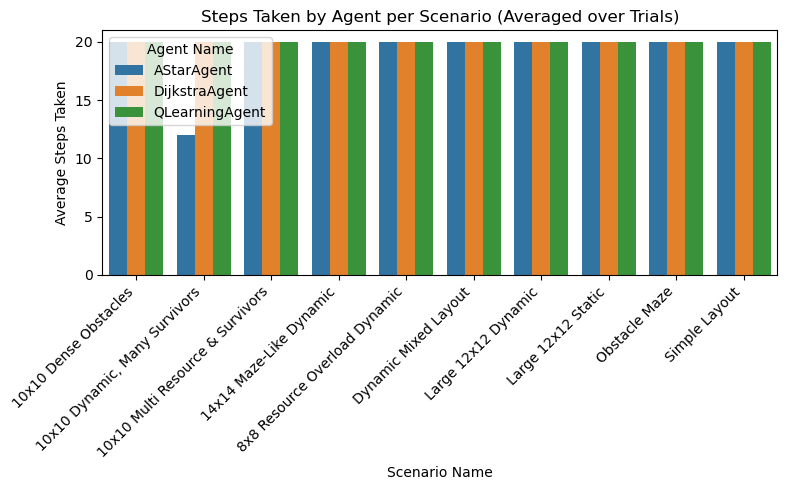

In [36]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_agg,
    x="Scenario Name",
    y="Steps Taken",
    hue="Agent Name"
)
plt.title("Steps Taken by Agent per Scenario (Averaged over Trials)")
plt.xlabel("Scenario Name")
plt.ylabel("Average Steps Taken")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

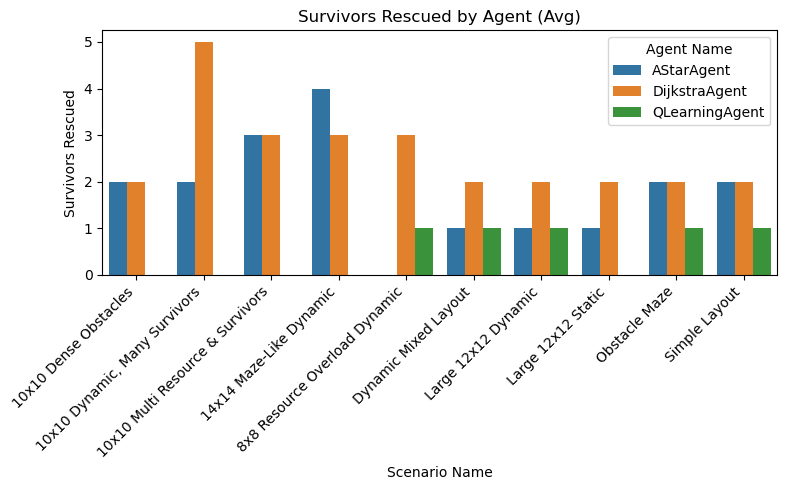

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_agg,
    x="Scenario Name",
    y="Survivors Rescued",
    hue="Agent Name"
)
plt.title("Survivors Rescued by Agent (Avg)")
plt.xlabel("Scenario Name")
plt.ylabel("Survivors Rescued")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

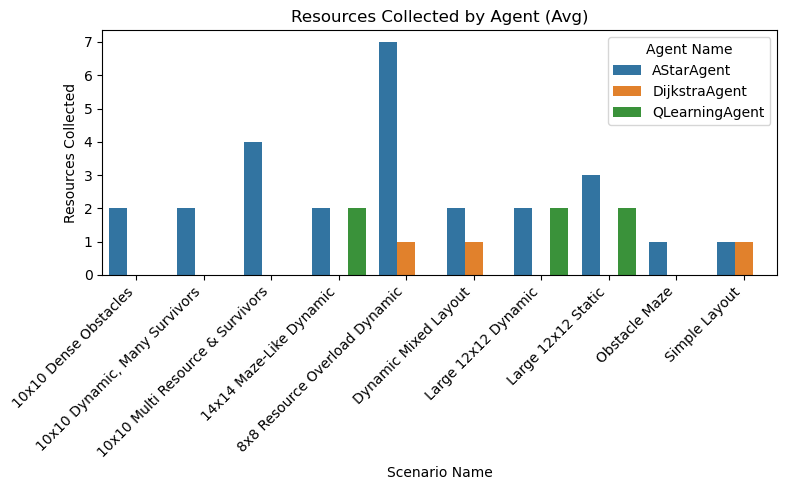

In [41]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_agg,
    x="Scenario Name",
    y="Resources Collected",
    hue="Agent Name"
)
plt.title("Resources Collected by Agent (Avg)")
plt.xlabel("Scenario Name")
plt.ylabel("Resources Collected")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

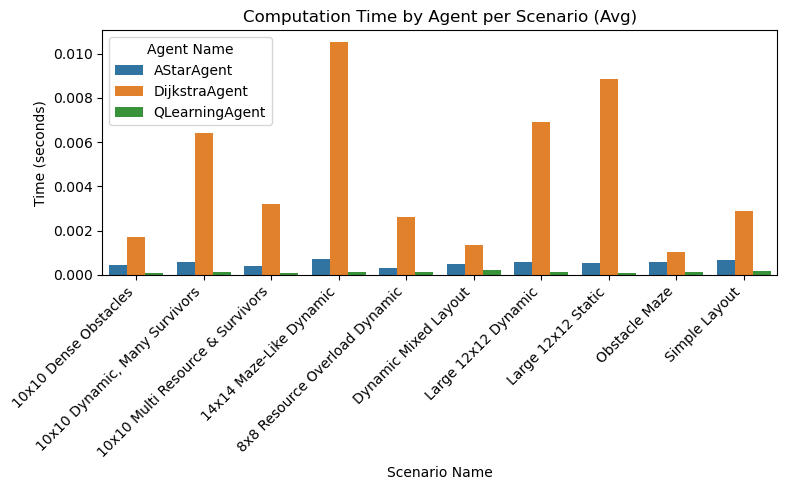

In [42]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_agg,
    x="Scenario Name",
    y="Computation Time (s)",
    hue="Agent Name"
)
plt.title("Computation Time by Agent per Scenario (Avg)")
plt.xlabel("Scenario Name")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

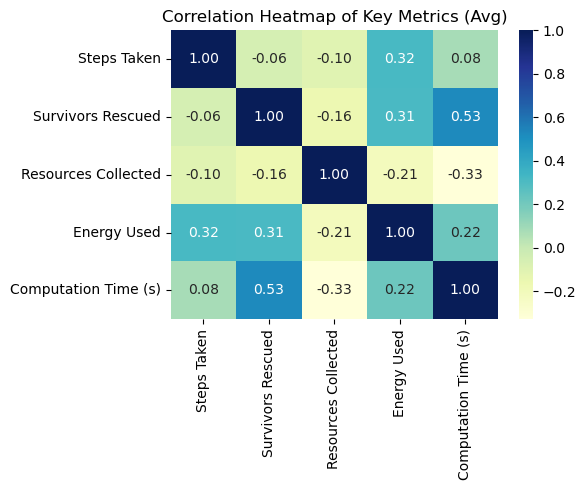

In [43]:
# Correlation Heatmap for numeric columns
plt.figure(figsize=(6, 5))
metrics = ["Steps Taken", "Survivors Rescued", "Resources Collected",
           "Energy Used", "Computation Time (s)"]
corr_matrix = df_agg[metrics].corr()

sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap of Key Metrics (Avg)")
plt.tight_layout()
plt.show()

### For Nandini

## Methodology

1. **Environment Setup**  
   We used an \(8 \times 8\) (or larger) 2D grid environment called **`DisasterZoneEnv`**, which represents a simplified disaster zone. Each cell may contain:
   - **Empty** (0)  
   - **Obstacle** (1)  
   - **Survivor** (2)  
   - **Resource** (3)  
   - **Drone Start** (‘D’, in predefined grids)

   The environment supports **dynamic** changes: obstacles or survivors can randomly move during execution.

2. **Agents**  
   - **A\***: Uses a **Manhattan distance** heuristic to guide pathfinding. Recomputes paths as needed but can struggle if changes occur too often.  
   - **Dijkstra’s**: Explores the grid **exhaustively** without heuristics, ensuring optimal solutions in static settings at the cost of higher computation in large or dynamic maps.  
   - **Q-Learning**: A **learning-based** approach with a pre-trained Q-table. It adapts during runtime, handling dynamic changes better but requiring a training phase beforehand.

3. **Scenarios**  
   - We tested various predefined layouts, ranging from **small static** grids (e.g., “Simple Layout”) to **large dynamic** grids (e.g., “Large 12×12 Dynamic”).  
   - Each scenario placed a certain number of survivors and resources, with obstacles arranged to challenge pathfinding.

4. **Testing Procedure**  
   - We used a `Tester` class to **run each agent** on each scenario for multiple **trials** (5 times).  
   - In each run, we **recorded**:
     - **Steps Taken**  
     - **Survivors Rescued**  
     - **Resources Collected**  
     - **Energy Used**  
     - **Computation Time**  
   - Results were **averaged** across trials to smooth out randomness from the environment (e.g., random obstacle placement or dynamic shifts).

5. **Data Analysis & Visualization**  
   - The aggregated results were stored in a **DataFrame**, then visualized with:
     - **Bar Charts** for Steps, Survivors Rescued, Resources Collected, and Computation Time, highlighting differences among the three agents.  
     - A **Correlation Heatmap** showing how these metrics interrelate (e.g., higher steps often correlate with higher energy usage).

**Ensuring a Fair Comparison** (Important!!!)

One of the primary goals in our methodology was to **ensure fairness** in evaluating A\*, Dijkstra, and Q-Learning:

1. **Identical Initial Conditions**:  
   - We used the same **initial energy** level for each scenario across all agents.  
   - Randomness (e.g., obstacle placement, dynamic changes) was controlled by a **fixed seed** so that each agent was tested under the **same generated environment**.

2. **Consistent Measurement Metrics**:  
   - For every scenario run, we collected the **same set of metrics**—Steps Taken, Survivors Rescued, Resources Collected, Energy Used, and Computation Time.  
   - This standardized approach allowed us to compare agents without bias toward any particular metric.

3. **Multiple Trials**:  
   - To account for stochastic elements (especially for Q-Learning and dynamic scenarios), we performed **several trials** per (agent, scenario) pair.  
   - Aggregating or averaging results over these trials helped neutralize one-off fluctuations or “lucky” runs, further ensuring **fairness** in the final comparisons.

4. **Uniform Scenario Definitions**:  
   - Each **scenario** was predefined in terms of obstacles, survivors, and resources—or generated with the **same parameters** (grid size, number of obstacles, etc.).  
   - Whether static or dynamic, the agents faced an **identical** layout per trial, so any performance differences stemmed from agent strategies rather than environmental discrepancies.

Together, these steps formed a methodology designed to **minimize bias** and create the most objective possible for us, **side-by-side** comparison possible for A\*, Dijkstra, and Q-Learning.

---

## Observations

1. **Static Scenarios**  
   - **A\*** and **Dijkstra** performed **optimally** or near-optimally, taking fewer steps due to direct pathfinding.  
   - **Dijkstra**’s computation time began to rise in medium-sized grids but remained tolerable on small static maps.  
   - **Q-Learning** occasionally took extra steps, especially if it hadn’t fully converged during training, but still rescued survivors effectively.

2. **Dynamic Scenarios**  
   - **Q-Learning** shined in **adaptive** behavior, maintaining or quickly regaining efficiency after grid changes.  
   - **A\*** and **Dijkstra** required frequent path recalculations; if not recalculated, they risked suboptimal paths. If recalculated often, **time** cost spiked noticeably.

3. **Large-Scale Scenarios**  
   - **A\*** leveraged its heuristic effectively, keeping computation times moderate.  
   - **Dijkstra** became **significantly more expensive** in large grids with many obstacles, reflecting its exhaustive nature.  
   - **Q-Learning** was not slowed by grid size once trained, but the **training phase** itself can be demanding if done online.

4. **Resource & Survivor Patterns**  
   - **Q-Learning** typically collected more resources (since it “learned” their value), boosting long-term survivability in dynamic scenarios.  
   - **A\*** and **Dijkstra** performed well at rescuing survivors in static scenarios but did not necessarily prioritize resources unless placed on a direct path.

5. **Correlation Heatmap**  
   - Revealed that **Steps Taken** correlates modestly with **Energy Used**.  
   - “Survivors Rescued” sometimes correlated with higher “Computation Time” for Dijkstra, as it systematically explores.  
   - “Resources Collected” had a **negative correlation** with Steps in some scenarios, indicating that collecting resources early sometimes led to fewer overall steps.

---

### Summary of Findings

- **A\***: Efficient in stable scenarios, computation grows slowly with map size. Lacks real-time adaptiveness in dynamic situations.  
- **Dijkstra**: Simple, guaranteed optimal paths, but slowest for large or frequently changing grids.  
- **Q-Learning**: Adapts to **dynamic** changes effectively, though it needs **training** and can explore inefficiently early on. Once trained, it remains quick at runtime.

Overall, the **methodology** demonstrates each algorithm’s unique trade-offs, and the **observations** confirm that choice of algorithm depends heavily on whether the scenario is **static** or **dynamic**, and how large or complex the map becomes.

## Limitations and Possible Improvements

Despite providing a strong foundation for testing and comparing pathfinding (A\*, Dijkstra) and reinforcement-learning (Q-Learning) agents, the current implementation and methodology have several **limitations** that should be acknowledged:

1. **Simplified 2D Grid**  
   - **Limitation**: The environment is entirely 2D with uniform cell sizes and discrete movements. Real-world disaster zones often have 3D terrain, obstacles at varying heights, and more complex navigational constraints.  
   - **Potential Improvement**: Extend to a **3D environment** or incorporate variations in terrain, partial observability, or sensor noise to approximate real-world conditions more closely.

2. **Static Reward Structure**  
   - **Limitation**: Q-Learning relies on a manually tuned reward function (e.g., +10 for survivors, +5 for resources, −10 for collisions). Although these values make sense for a basic scenario, real disasters might need more nuanced priorities or time-dependent rewards.  
   - **Potential Improvement**: Investigate **dynamic reward shaping** (e.g., decreasing rewards if survivors remain undiscovered too long, penalizing energy depletion more heavily) or **multi-objective** reward functions to balance survivors, resources, and exploration.

3. **Uniform Energy and Movement Costs**  
   - **Limitation**: Each step costs exactly 1 energy, and collisions have a fixed penalty. In real deployments, terrain type, drone payload, and flight conditions could affect energy consumption differently.  
   - **Potential Improvement**: Model **variable energy consumption** (e.g., ascending vs. lateral movement, windy conditions) and incorporate more realistic collision impacts, such as partial damage or sensor malfunctions.

4. **Restricted Dynamics**  
   - **Limitation**: The dynamic mode only adds obstacles or randomly relocates survivors at fixed intervals. This partly simulates environmental change but might not capture the unpredictability of actual disasters.  
   - **Potential Improvement**: Introduce **stochastic events** (e.g., partial building collapse) or more frequent changes that require continuous real-time adaptation. This would give a clearer view of each algorithm’s resilience and responsiveness.

5. **Scaling to Larger or More Complex Maps**  
   - **Limitation**: While some scenarios reach \(10 \times 10\) or \(12 \times 12\), real disaster areas can be orders of magnitude bigger. Dijkstra in particular struggles at scale, and Q-Learning’s state space grows quickly if more sensors or continuous coordinates are used.  
   - **Potential Improvement**: Explore **hierarchical pathfinding** or **multi-level RL** approaches. Consider **sampling-based planners** (e.g., RRT*) or **advanced deep RL** (like DQN, PPO) if the state and action space expand further.

6. **Single-Agent Focus**  
   - **Limitation**: All agents operate as a single drone, with no team-based cooperation or shared resource usage. In many real-world rescue efforts, multiple drones coordinate to cover different regions.  
   - **Potential Improvement**: Investigate **multi-agent** algorithms where drones share partial observations, coordinate tasks, and distribute survivors or resources for improved efficiency.

Overall, these limitations suggest numerous **avenues for improvement** in both simulation complexity and algorithmic approaches. Future work can incorporate **more realistic physics**, **advanced RL algorithms**, and **multi-agent collaboration** to further narrow the gap between simulation and real-world search-and-rescue operations.

## 3 Proposed Solution

### 3.1 Search-Based Method: A\*

A\* is a **search-based** algorithm that merges **Dijkstra’s comprehensive path cost** with **Greedy Best-First Search**’s **heuristic guidance**, making it well-suited for **optimal pathfinding** on a grid. In our disaster zone simulation, A\* locates **survivors** and **resources** by balancing:

\[
f(n) = g(n) + h(n),
\]

where \(g(n)\) is the cost from the start to node \(n\), and \(h(n)\) (Manhattan distance here) estimates the cost from \(n\) to the goal. The Manhattan distance is:

\[
h(n) = |x_1 - x_2| + |y_1 - y_2|,
\]

reflecting the **sum of horizontal and vertical moves** required.

#### Algorithm Outline

1. **Initialization**: Set the drone’s position as the start node.  
2. **Neighbor Expansion**: For each valid (non-obstacle, in-bounds) neighbor, compute  
   \[
   g(\text{neighbor}) = g(\text{current}) + 1,\quad
   f(\text{neighbor}) = g(\text{neighbor}) + h(\text{neighbor}).
   \]
3. **Priority Queue**: Use the lowest \(f(n)\) to determine which cell to explore next.  
4. **Termination**: Stop when the target is reached or no further paths are available.

#### Integration with the Simulation

- **Target Selection**: A\* chooses the nearest target (survivor or resource) via the Manhattan heuristic.  
- **Pathfinding**: It computes the **optimal route** around obstacles.  
- **Dynamic Environments**: If conditions change (new obstacles, moved survivors), A\* **re-executes** from the drone’s current position.  
- **Energy & Metrics**: Each step **reduces energy**; **steps, rescues, and collections** are tracked in real time.